In [1]:
"""
created on 2 Feb 2019

@author: Super Huan
"""


'\ncreated on 2 Feb 2019\n\n@author: Super Huan\n'

In [1]:
from keras.applications import VGG16
import warnings
warnings.filterwarnings('ignore')

F:\Anaconda\Anaconda3.5\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# weights 指定模型初始化的权重检查点
# include_top 制定模型最后是否包含密集连接分类器。默认的情况下，这个密集连接分类器对应于ImageNet的1000个类别。
# 因为我们打算使用自己的密集连接分类器所以不需要包含它
# input_shape 输入张量的形状

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

# 不适用数据增强的快速特征提取

In [5]:
# 使用有预练的卷积基特征提取
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'F:/PythonDemo/BooksMyDemo/Deep Learning with Python/chapter 5/dogs_vs_cats_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [14]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size:(i +1) * batch_size] = features_batch
        labels[i * batch_size:(i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [15]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [16]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [21]:
# 定义并训练密集连接分类器
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6057 - acc: 0.6685 - val_loss: 0.4387 - val_acc: 0.8300
Epoch 2/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.4216 - acc: 0.8140 - val_loss: 0.3607 - val_acc: 0.8630
Epoch 3/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3561 - acc: 0.8460 - val_loss: 0.3315 - val_acc: 0.8650
Epoch 4/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3129 - acc: 0.8705 - val_loss: 0.3023 - val_acc: 0.8760
Epoch 5/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2900 - acc: 0.8825 - val_loss: 0.2877 - val_acc: 0.8850
Epoch 6/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2686 - acc: 0.8830 - val_loss: 0.2781 - val_acc: 0.8850
Epoch 7/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2439 - acc: 0.9070 - val_loss: 0.2633 - val_acc: 0.8920
Epoch 8/30
200

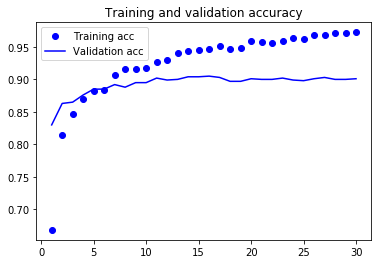

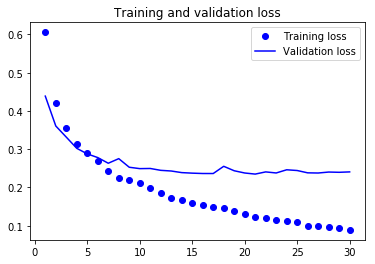

In [24]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 使用数据增强的特征提取

In [26]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [27]:
print('This is the number of trainable weghts before freezing the conv base: ', len(model.trainable_weights))
conv_base.trainable = False # 设置 freezing 训练是该网络参数不会改变,如此设置完以后只有Dense层的参数会改变
print('This is the number of trainable weights:', len(model.trainable_weights))

This is the number of trainable weghts before freezing the conv base:  30
This is the number of trainable weights: 4


In [30]:
# 利用冻结的卷积基端到端地训练模型
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255) # 验证数据不可以增强

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit_generator(train_generator, steps_per_epoch=200, epochs=15, validation_data=validation_generator, validation_steps=100)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/15
200/200 [==============================] - 74s 370ms/step - loss: 0.5405 - acc: 0.7313 - val_loss: 0.3822 - val_acc: 0.8480
Epoch 2/15
200/200 [==============================] - 72s 360ms/step - loss: 0.4273 - acc: 0.8065 - val_loss: 0.3076 - val_acc: 0.8800
Epoch 3/15
200/200 [==============================] - 72s 362ms/step - loss: 0.3869 - acc: 0.8300 - val_loss: 0.2821 - val_acc: 0.8870
Epoch 4/15
200/200 [==============================] - 81s 404ms/step - loss: 0.3665 - acc: 0.8383 - val_loss: 0.2713 - val_acc: 0.8860
Epoch 5/15
200/200 [==============================] - 89s 446ms/step - loss: 0.3509 - acc: 0.8448 - val_loss: 0.2784 - val_acc: 0.8880
Epoch 6/15
200/200 [==============================] - 101s 505ms/step - loss: 0.3416 - acc: 0.8508 - val_loss: 0.2601 - val_acc: 0.8890
Epoch 7/15
200/200 [==============================] - 111s 556ms/step - loss: 0.3341 - acc: 0.8560 - val_

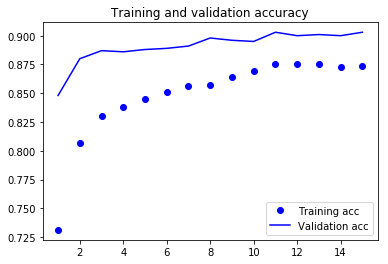

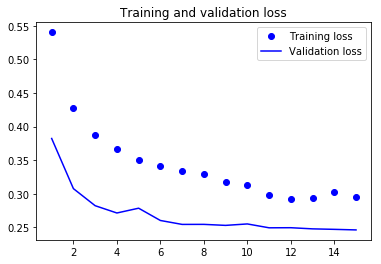

In [31]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 模型微调 

In [32]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [33]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv_1':
        set_trainable = True
    if set_trainable:
        set_trainable = True
    else:
        layer.trainable = False

In [35]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

history = model.fit_generator(train_generator, steps_per_epoch=200, epochs=10, validation_data=validation_generator, validation_steps=100)

Epoch 1/10
200/200 [==============================] - 72s 359ms/step - loss: 0.2861 - acc: 0.8785 - val_loss: 0.2456 - val_acc: 0.9000
Epoch 2/10
200/200 [==============================] - 76s 382ms/step - loss: 0.2827 - acc: 0.8775 - val_loss: 0.2466 - val_acc: 0.8960
Epoch 3/10
200/200 [==============================] - 86s 430ms/step - loss: 0.2909 - acc: 0.8755 - val_loss: 0.2467 - val_acc: 0.9040
Epoch 4/10
200/200 [==============================] - 98s 492ms/step - loss: 0.2835 - acc: 0.8802 - val_loss: 0.2483 - val_acc: 0.9030
Epoch 5/10
200/200 [==============================] - 108s 541ms/step - loss: 0.2826 - acc: 0.8782 - val_loss: 0.2472 - val_acc: 0.9060
Epoch 6/10
200/200 [==============================] - 115s 574ms/step - loss: 0.2775 - acc: 0.8835 - val_loss: 0.2473 - val_acc: 0.9040
Epoch 7/10
200/200 [==============================] - 123s 616ms/step - loss: 0.2784 - acc: 0.8832 - val_loss: 0.2495 - val_acc: 0.9000
Epoch 8/10
200/200 [==============================] 

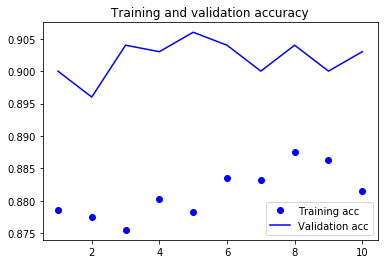

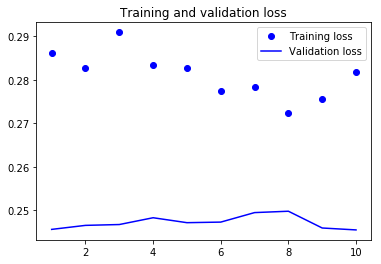

In [36]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()